<a href="https://colab.research.google.com/github/Antana-A/Explore-Diabetes-Dataset-with-Principle-Component-Analysis-and-Logistics-Regression-/blob/main/Non-Negative%20Matrix%20Factorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

# Load the CSV files
train_rna = pd.read_csv("/content/drive/MyDrive/training_set_rna.csv",index_col=0).values
train_adt = pd.read_csv("/content/drive/MyDrive/training_set_adt.csv",index_col=0).values
test_rna= pd.read_csv("/content/drive/MyDrive/test_set_rna.csv",index_col=0).values


Mounted at /content/drive


In [4]:
# Subset the data as specified
train_rna_subset = train_rna[:,:3000]
train_adt_subset = train_adt[:,:3000]
test_rna_subset = train_rna[:,3000:]
test_adt_subset = train_adt[:,3000:]
train_adt_subset.shape,train_rna_subset.shape, test_rna_subset.shape, test_adt_subset.shape

((25, 3000), (639, 3000), (639, 1000), (25, 1000))

# Build a Linear Regression Model
Build a linear regression model for each of the ADT proteins using Ordinary Least Squares (OLS), and evaluate the results using Pearson correlation,

In [5]:
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import numpy as np

# Initialize lists to store results
pearson_correlations = []

# Loop through each ADT protein in train_adt_subset
for i in range(train_adt_subset.shape[0]):
    # Select the target protein expression (y) for the current ADT protein
    y_train = train_adt_subset[i, :]

    # Create and fit the OLS linear regression model
    model = LinearRegression()
    model.fit(train_rna_subset.T, y_train)

    # Predict the protein expression for the test set
    y_pred = model.predict(test_rna_subset.T)

    # Evaluate the model using Pearson correlation
    correlation, _ = pearsonr(y_pred, test_adt_subset[i, :])
    pearson_correlations.append(correlation)

# Convert results to a numpy array
pearson_correlations = np.array(pearson_correlations)

# Display the Pearson correlations for all proteins
pearson_correlations


array([0.88385489, 0.93963586, 0.74151062, 0.8182871 , 0.9365866 ,
       0.80511447, 0.75579921, 0.88321214, 0.36972054, 0.33593533,
       0.86002173, 0.71316232, 0.8248176 , 0.86507552, 0.64746707,
       0.74172601, 0.76759417, 0.73362302, 0.68533764, 0.58452872,
       0.42367089, 0.68483451, 0.69235895, 0.7859804 , 0.86545107])

In [6]:
#Adding an intercept term to the model raises the correlation slightly.
# Refit models with intercept explicitly included
pearson_correlations_with_intercept = []

for i in range(train_adt_subset.shape[0]):
    # Select the target protein expression (y) for the current ADT protein
    y_train = train_adt_subset[i, :]

    # Create and fit the OLS linear regression model with intercept
    model = LinearRegression(fit_intercept=True)
    model.fit(train_rna_subset.T, y_train)

    # Predict the protein expression for the test set
    y_pred = model.predict(test_rna_subset.T)

    # Evaluate the model using Pearson correlation
    correlation, _ = pearsonr(y_pred, test_adt_subset[i, :])
    pearson_correlations_with_intercept.append(correlation)

# Convert results to a numpy array
pearson_correlations_with_intercept = np.array(pearson_correlations_with_intercept)

# Display the Pearson correlations for all proteins with intercept
pearson_correlations_with_intercept



array([0.88385489, 0.93963586, 0.74151062, 0.8182871 , 0.9365866 ,
       0.80511447, 0.75579921, 0.88321214, 0.36972054, 0.33593533,
       0.86002173, 0.71316232, 0.8248176 , 0.86507552, 0.64746707,
       0.74172601, 0.76759417, 0.73362302, 0.68533764, 0.58452872,
       0.42367089, 0.68483451, 0.69235895, 0.7859804 , 0.86545107])

# Predicting using Non-negative Matrix Factorization
Nmf is used to obtain a matrix W, which contains the features embedding and matrix H which contains the sample embeddings on the train data then we project the results to the test RNA to get test sample embeddings then predict the test ADT.

In [7]:
import numpy as np

def nmf(X, k, max_iter=1000, verbose=True):
    if verbose:
        print(f"Performing NMF with k = {k}")
    # Randomly initialize W and initialize H with small positive values to prevent zero division
    np.random.seed(42)
    W = np.random.rand(X.shape[0], k)
    H = np.zeros((k, X.shape[1])) + 1e-15

    for i in range(max_iter):
        # Update H and W alternatingly using ALS (Alternating Least Squares)
        H *= np.dot(W.T, X) / (np.dot(np.dot(W.T, W), H) + 1e-15)
        W *= np.dot(X, H.T) / (np.dot(W, np.dot(H, H.T)) + 1e-15)

    return W, H

def get_H_test(A, W, k, num_iterations=100):
    # Randomly initialize H with correct dimensions
    H_hat = np.random.rand(k, A.shape[1])

    for i in range(num_iterations):
        # Update H_hat using least squares solution
        H_hat = np.linalg.lstsq(W.T.dot(W), W.T.dot(A), rcond=None)[0]
        # Apply non-negativity constraint
        H_hat[H_hat < 0] = 0

    return H_hat

# Combine ADT and RNA features into a single matrix A
A = np.vstack((train_adt_subset, train_rna_subset))

nmf_cors = {}

# Loop over values of k to find an optimal rank for NMF
for k in range(10, 300, 10):
    W, H = nmf(A, k, verbose=False)
    H_test = get_H_test(test_rna_subset, W[25:], k)
    adt_predictions = W[:25].dot(H_test)
    # Calculate Pearson correlation for NMF predictions
    nmf_cors[k] = np.corrcoef(adt_predictions.flatten(), test_adt_subset.flatten())[0, 1]

nmf_cors



{10: 0.7179013835165015,
 20: 0.7643283527472448,
 30: 0.764358766427834,
 40: 0.7746734355470745,
 50: 0.7794378696969156,
 60: 0.771861257202653,
 70: 0.7802283009132202,
 80: 0.7814973024902969,
 90: 0.7766157483132857,
 100: 0.7766676619331525,
 110: 0.7803959242129005,
 120: 0.782311390443399,
 130: 0.7769175406476553,
 140: 0.7784171102399131,
 150: 0.7725428335418149,
 160: 0.7750842703745662,
 170: 0.7733730195574607,
 180: 0.7672883059133064,
 190: 0.7715214418097933,
 200: 0.7681471631489546,
 210: 0.7731767555206239,
 220: 0.7649582714016627,
 230: 0.7556746356228806,
 240: 0.7497908479297919,
 250: 0.7568082494819177,
 260: 0.7652003349519764,
 270: 0.7720277307071952,
 280: 0.7421688434490142,
 290: 0.7625901030194697}

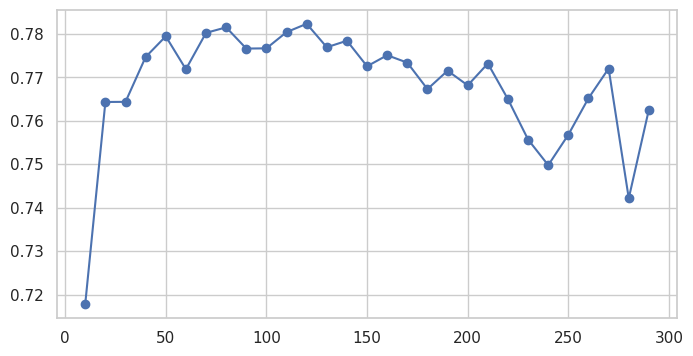

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
sns.set_palette(None)
plt.figure(figsize=(8,4))

plt.plot(nmf_cors.keys(),nmf_cors.values(),marker="o")

In [9]:
f"highest NMF:{sorted(nmf_cors.values())[-1]}"

'highest NMF:0.782311390443399'

The highest correlation nmf achieves is 0.78, which means linear regression is a better performing model.

# Exploring Other Regression Models.
There are numerous regression models available. We selected a few of the best-performing ones to compare against linear regression.

In [1]:
pip install "dask[dataframe]"

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.2/242.2 kB 5.7 MB/s eta 0:00:00


In [10]:

from sklearn.linear_model import Ridge, Lasso, ElasticNet,SGDRegressor,BayesianRidge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from xgboost.sklearn import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr,uniform,expon
from time import process_time

def test_estimators(estimators,verbose=False):
  results = {}
  ground_truths = test_adt_subset.flatten()
  # Fit models and calculate Pearson correlation
  for estimator_name, estimator in estimators:
    predictions = []
    start = process_time()

    for i,y in enumerate(train_adt_subset):
      if verbose:
        print(f"Evaluating {estimator}, iteration {i+1}")
      estimator.fit(train_rna_subset.T, y.T)

      y_pred = estimator.predict(test_rna_subset.T)
      predictions.extend(y_pred)

    mse = mean_squared_error(ground_truths, predictions)
    correlation, _ = pearsonr(ground_truths, predictions)

    end = process_time()

    results[estimator_name] = {
        'mse': mse,
        "correlation": correlation,
        "time": (end-start)/60
    }
  return results

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [12]:
estimators = [
      ("LGBMRegressor",LGBMRegressor()),
      ("XGBRegressor",XGBRegressor()),
      ("BayesianRidge",BayesianRidge()),
      ('Ridge', Ridge()),
      ('Lasso', Lasso()),
      ("SVR", SVR()),
      ('ElasticNet', ElasticNet()),
      ('KNeighborsRegressor', KNeighborsRegressor()),
      ('DecisionTreeRegressor', DecisionTreeRegressor()),
      ('GradientBoostingRegressor', GradientBoostingRegressor()),
      ('AdaBoostRegressor', AdaBoostRegressor()),
  ]
results = test_estimators(estimators)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.238704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 154063
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 639
[LightGBM] [Info] Start training from score 0.799801
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.158733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 154063
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 639
[LightGBM] [Info] Start training from score 0.899641
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 154063
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 639
[LightGBM] [Info] Sta

In [13]:

for estimator_name, result in results.items():
    print("*"*30)
    print(f"{estimator_name}:")
    print(f"Mean Squared Error: {result['mse']:.3f}")
    print(f"Pearson Correlation: {result['correlation']:.3f}")
    print(f"Time in minutes: {result['time']:.2f}")
    print('*'*30,"\n")

******************************
LGBMRegressor:
Mean Squared Error: 0.125
Pearson Correlation: 0.853
Time in minutes: 3.83
****************************** 

******************************
XGBRegressor:
Mean Squared Error: 0.142
Pearson Correlation: 0.831
Time in minutes: 20.55
****************************** 

******************************
BayesianRidge:
Mean Squared Error: 0.153
Pearson Correlation: 0.816
Time in minutes: 0.64
****************************** 

******************************
Ridge:
Mean Squared Error: 0.171
Pearson Correlation: 0.798
Time in minutes: 0.15
****************************** 

******************************
Lasso:
Mean Squared Error: 0.424
Pearson Correlation: 0.311
Time in minutes: 0.05
****************************** 

******************************
SVR:
Mean Squared Error: 0.142
Pearson Correlation: 0.833
Time in minutes: 1.81
****************************** 

******************************
ElasticNet:
Mean Squared Error: 0.377
Pearson Correlation: 0.472
Time i

Text(0.5, 1.0, 'SVM linear separation in 2 Dimensions')

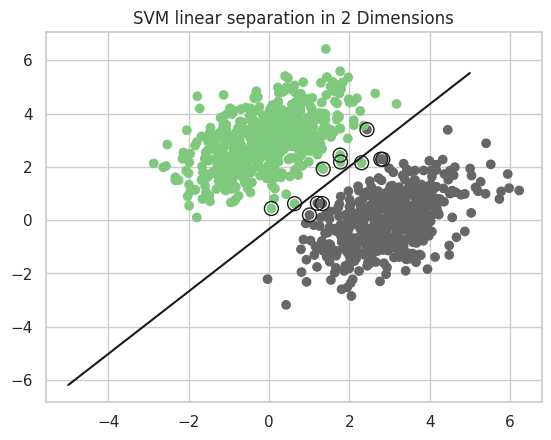

In [15]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt

# Create some dummy data for two classes
np.random.seed(1)
negatives = np.random.multivariate_normal([3,0],[[1,.5],[.5,1]],500)#pass mean and covariance matrix of the dummy multivariate normal distribution
positives = np.random.multivariate_normal([0,3],[[1,.5],[.5,1]],500)
X = np.r_[negatives,positives]
y = [0]*500 + [1]*500

svc = SVC(kernel='linear')
svc.fit(X, y)

# plot hyperplane by expressing line [w[0],w[1]].[x,y]+b=0 into y=mx+c form.
w = svc.coef_[0]
xx = np.linspace(-5, 5)
yy = -w[0]/w[1] * xx - (svc.intercept_[0])/w[1]

plt.scatter(X[:, 0], X[:, 1], c=y,cmap="Accent_r")

plt.scatter(svc.support_vectors_[:, 0], svc.support_vectors_[:, 1], s=100, facecolors='none', edgecolors='k')#apply styling to support vectors
plt.plot(xx, yy, 'k-')

plt.title("SVM linear separation in 2 Dimensions")



# Tuning Support Vector Regression
Let's try to fine-tune SVR to see if we'll get a better fit. Hyperparameter tuning can be computationally intensive and thus we should choose to fine-tune only parameters that are important. To impose non-linearity, we use rbf as the kernel function.

In [1]:
def search(params,search_type="random",num=5):
  from itertools import product

  search_combos = list(product(*params.values()))
  search_parameters = [dict(zip(params.keys(), combination)) for combination in search_combos]
  if search_type.lower() == 'grid':
    pass
  else:
    import random
    random.seed(6495)
    try:
      search_parameters = random.sample(search_parameters,num)
    except ValueError:
      print("parameter num exceeds search space... using grid")
  params_results = []
  for param_combo in search_parameters:
      params_results.append((param_combo,test_estimators([("SVR",SVR(**param_combo))],False)))

  return params_results

In [14]:

params = {
      'C': [1, 2,3,4],
      'kernel': ['rbf'],
      'gamma': ["auto","scale"],
      'degree': [1],# degree parameter is only useful to tune in polynomial kernels
      'epsilon': [.001,.01]
  }
results = search(params,'grid')


In [16]:
l = sorted([(param_combo,result["SVR"]["correlation"]) for  param_combo,result in results],key=lambda x:x[1],reverse=True)
l[:3]

[({'C': 2, 'kernel': 'rbf', 'gamma': 'auto', 'degree': 1, 'epsilon': 0.01},
  0.8496138437184753),
 ({'C': 2, 'kernel': 'rbf', 'gamma': 'auto', 'degree': 1, 'epsilon': 0.001},
  0.8495893234617047),
 ({'C': 3, 'kernel': 'rbf', 'gamma': 'auto', 'degree': 1, 'epsilon': 0.001},
  0.8487801953987102)]

In [17]:
predictions = []
estimator = SVR(**{'C': 2, 'kernel': 'rbf', 'gamma': 'auto', 'degree': 2, 'epsilon': 0.001})
for y in train_adt:
  estimator.fit(train_rna.T, y.T)
  y_pred = estimator.predict(test_rna.T)
  predictions.append(y_pred)


In [18]:
predicted_flattened = np.array(predictions).T.flatten()

In [19]:
submission = pd.DataFrame({"ID":[f"ID_{i+1}" for i in range(len(predicted_flattened))], "Expected":predicted_flattened})
submission.to_csv("CIS_678_project2_submission.csv", index=False)

In [20]:
from google.colab import files
files.download("CIS_678_project2_submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>